## Plot de las dinamicas de casos diarios usando delta=5 para: RM, America, Europa

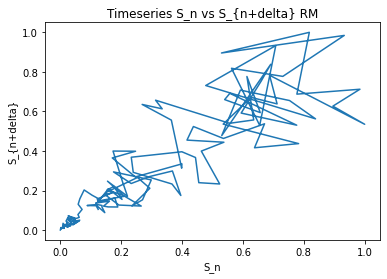

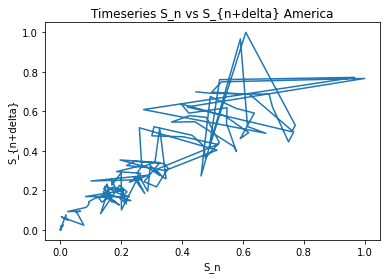

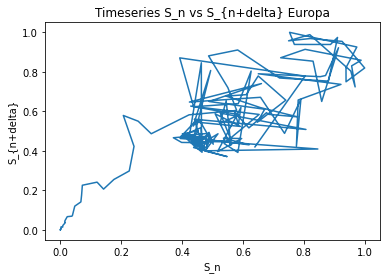

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nolds
from nolitsa import lyapunov,dimension,delay,noise


delta=4
data = pd.read_excel (r'C:\Users\javie\Desktop\Modelamiento\Datos\de maass\covid19 CHILE REGIONES-CURSOMM.xlsx', sheet_name='Casos')
df = pd.DataFrame(data, columns= ['fecha','RM','Maule','Valparaiso'])

#RM
timeseries=np.array(df.RM)[:-147]
timeseriesd=np.array(df.RM)[delta:-147]
X=timeseries/max(timeseries)
Y=timeseriesd/max(timeseriesd)
plt.figure()
plt.plot(X[:-delta],Y)
plt.title('Timeseries S_n vs S_{n+delta} RM')
plt.ylabel('S_{n+delta}')
plt.xlabel('S_n')

data2 = pd.read_excel (r'C:\Users\javie\Desktop\Modelamiento\Datos\de maass\CONTINENTES-2-CursoMM.xlsx')
df = pd.DataFrame(data2, columns= ['PacíficoOestenew','Américanew','Europanew'])

#America
timeseries=np.array(df.Américanew)[:-3]
timeseriesd=np.array(df.Américanew)[delta:-3]
X=timeseries/max(timeseries)
Y=timeseriesd/max(timeseriesd)
plt.figure()
plt.plot(X[:-delta],Y)
plt.title('Timeseries S_n vs S_{n+delta} America')
plt.ylabel('S_{n+delta}')
plt.xlabel('S_n')

#Europa
timeseries=np.array(df.Europanew)[:-3]
timeseriesd=np.array(df.Europanew)[delta:-3]
timeseries=np.delete(timeseries, 164, axis=0)
timeseriesd=np.delete(timeseriesd, 164-delta, axis=0)
X=timeseries/max(timeseries)
Y=timeseriesd/max(timeseriesd)
plt.figure()
plt.plot(X[:-delta],Y)
plt.title('Timeseries S_n vs S_{n+delta} Europa')
plt.ylabel('S_{n+delta}')
plt.xlabel('S_n')
plt.show()


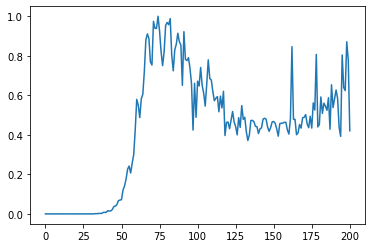

In [143]:
plt.plot(range(len(X)),X)
plt.show()

# Estimaciones de exponentes de lyapunov para la timeseries de casos diarios RM. (Utilizando la libreria nolitsa).

In [144]:
#Funcion util para encontrar minimos locales.
def localmin(x):
    """Return all local minima from the given data set.
    Returns all local minima from the given data set.  Note that even
    "kinky" minima (which are probably not real minima) will be
    returned.
    Parameters
    ----------
    x : array
        1D scalar data set.
    Returns
    -------
    i : array
        Array containing location of all local minima.
    """
    return (np.diff(np.sign(np.diff(x))) > 0).nonzero()[0] + 1

Para estimar mayor exponente de Lyapunov es necesario antes obtener valores para la dimension de inmersion, el tiempo de retardo.

In [145]:
#Importamos la data.
data = pd.read_excel (r'C:\Users\javie\Desktop\Modelamiento\Datos\de maass\covid19 CHILE REGIONES-CURSOMM.xlsx', sheet_name='Casos')
df = pd.DataFrame(data, columns= ['fecha','RM','Maule','Valparaiso'])
#RM
timeseries=np.array(df.RM)[:-147]
timeseriesd=np.array(df.RM)[delta:-147]
X=timeseries/max(timeseries)

# Estimación: Tiempo de retardo.

Un criterio para encontrar un tiempo de retardo óptimo es minimizando la función de informacion mutua.

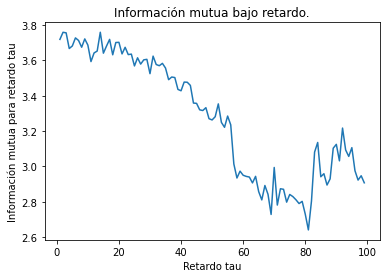

In [146]:
#Calculo de la información mutua entre X_t, X_(t+tau)
time_delay=np.zeros(99)
for tau in range(1,100):
    td=delay.mi(X[:-tau],X[tau:])
    time_delay[tau-1]=td
plt.plot(range(1,100),time_delay)
plt.title('Información mutua bajo retardo.')
plt.xlabel('Retardo tau')
plt.ylabel('Información mutua para retardo tau')
plt.show()

In [147]:
print('Los mínimos locales se alcanzan para tau='+ str(localmin(time_delay)+1))

Los mínimos locales se alcanzan para tau=[ 4  8 11 15 18 21 23 25 27 30 33 36 40 47 50 54 58 63 66 69 71 74 78 81
 85 87 91 94 97]


Otro criterio puede ser escogiendo el valor mínimo para la función autocorrelación:

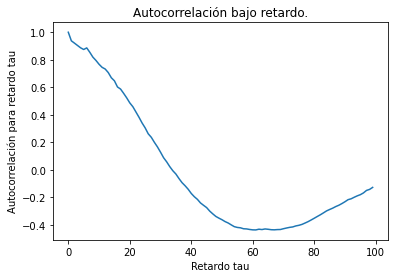

In [148]:
r = delay.acorr(X, maxtau=100)
plt.plot(range(0,100),r)
plt.title('Autocorrelación bajo retardo.')
plt.xlabel('Retardo tau')
plt.ylabel('Autocorrelación para retardo tau')
plt.show()

In [149]:
localmin(r)

array([ 5, 61, 63, 67], dtype=int64)

Encontramos un minimo local para tau=5, consideramos finalmente tiempo de retardo tau=5.

# Estimación: Dimensión de inmersión.

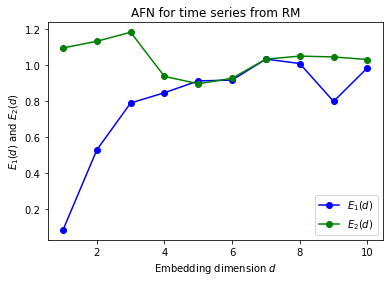

In [150]:
# AFN algorithm.
dim = np.arange(1, 10 + 2)
E, Es = dimension.afn(X, tau=5, dim=dim, window=10)
E1, E2 = E[1:] / E[:-1], Es[1:] / Es[:-1]

plt.title(r'AFN for time series from RM')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'$E_1(d)$ and $E_2(d)$')
plt.plot(dim[:-1], E1, 'bo-', label=r'$E_1(d)$')
plt.plot(dim[:-1], E2, 'go-', label=r'$E_2(d)$')
plt.legend()

plt.show()

E1(d) deja de variar cuando d es mayor que la embedding dimension, acercandose a 1. 
Por otro lado, E2(d) se usa para distinguir las señales deterministas de las estocasticas. Para señales deterministas, existe algun de tal que E2(d)!=1. Para señales estocasticas, E2(d) es aproximadamente 1 para todos los valores.

E1 se estabiliza cerca de un a partir de dimension 4, por lo que escogemos esta, ademas, E2 es distinto de 1 para bastantes valores de d, por lo cual la señar es determinista.

# Estimación: Exponente de Lyapunov.

Realizaremos las estimaciones de exponentes de Lyapunov utilizando dimension de inmersion 4.

Aún no tengo una forma de encontrar Theiler window optimo.

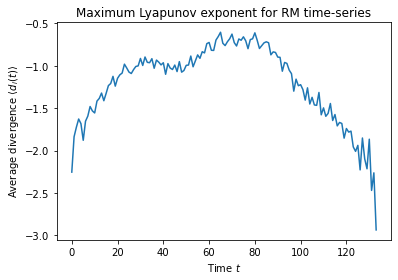

In [151]:
LEs=lyapunov.mle_embed(X, dim=[4], tau=5, window=10, maxt=500)[0]
plt.plot(range(len(LEs)),LEs)
plt.title('Maximum Lyapunov exponent for RM time-series')
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.show()

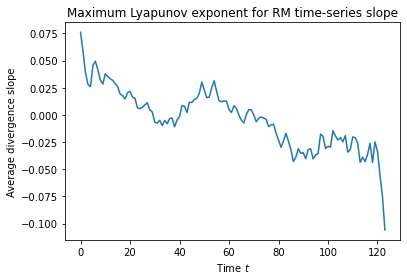

In [161]:
plt.title('Maximum Lyapunov exponent for RM time-series slope')
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence slope')
plt.plot(range(len(sma)),np.gradient(sma))
plt.show()

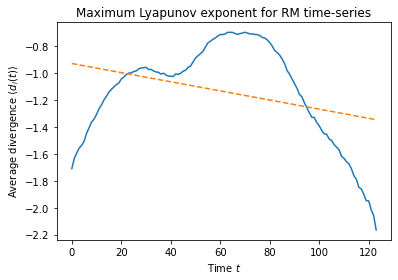

-0.0033973776636476616


In [160]:
sma=noise.sma(LEs, hwin=5)
plt.title('Maximum Lyapunov exponent for RM time-series')
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.plot(range(len(sma)),sma)
p = np.polyfit(range(len(sma)), sma,deg=1)
xaxis = range(len(sma))
yaxis = p[1] + p[0] * xaxis
plt.plot(xaxis, yaxis, '--')
plt.show()
print(p[0])

El maximo valor de exponente de Lyapunov encontrado es negativo, por lo cual el sistema no es caotico.

# Estimaciones de exponentes de lyapunov para la timeseries de casos diarios RM. (Utilizando la libreria nolds)

In [162]:
MLE=nolds.lyap_r(X, emb_dim=4, lag=4, min_tsep=None, tau=1, 
             min_neighbors=20, trajectory_len=20, fit='RANSAC', 
             debug_plot=False, debug_data=False, plot_file=None, fit_offset=0)
"""Args:
data (iterable of float):
(one-dimensional) time series
Kwargs:
emb_dim (int):
embedding dimension for delay embedding
lag (float):
lag for delay embedding
min_tsep (float):
minimal temporal separation between two “neighbors” (default: find a suitable value by calculating the mean period of the data)
tau (float):
step size between data points in the time series in seconds (normalization scaling factor for exponents)
min_neighbors (int):
if lag=None, the search for a suitable lag will be stopped when the number of potential neighbors for a vector drops below min_neighbors
trajectory_len (int):
the time (in number of data points) to follow the distance trajectories between two neighboring points
fit (str):
the fitting method to use for the line fit, either ‘poly’ for normal least squares polynomial fitting or ‘RANSAC’ for RANSAC-fitting which is more robust to outliers
debug_plot (boolean):
if True, a simple plot of the final line-fitting step will be shown
debug_data (boolean):
if True, debugging data will be returned alongside the result
plot_file (str):
if debug_plot is True and plot_file is not None, the plot will be saved under the given file name instead of directly showing it through plt.show()
fit_offset (int):
neglect the first fit_offset steps when fitting
Returns:
float:
an estimate of the largest Lyapunov exponent (a positive exponent is a strong indicator for chaos)"""
print(MLE)

0.027691502275323493


C:\Users\javie\anaconda3\lib\site-packages\nolds\measures.py:240: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 40
  warnings.warn(msg.format(min_tsep), RuntimeWarning)


In [165]:
MLE=np.zeros(50)
for k in range(50):
    MLE[k]=nolds.lyap_r(X, emb_dim=4, lag=4, min_tsep=k, tau=1, 
                 min_neighbors=20, trajectory_len=20, fit='RANSAC', 
                 debug_plot=False, debug_data=False, plot_file=None, fit_offset=0)

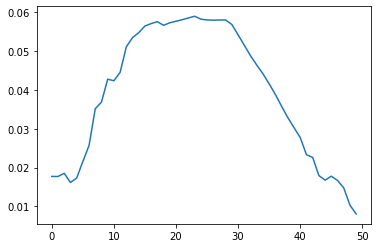

In [166]:
plt.plot(range(50),MLE)

In [167]:
min(MLE)

0.008069958141997725